# やること

- これまで使ってたモデルは本当に正しいのか？
  - いろいろ可視化してみる
- layer ごとにわかりやすく実装する


In [130]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torch import nn, optim
from torchinfo import summary
from torchview import draw_graph
from torchviz import make_dot

# 乱数固定用の処理
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


# これまで使ってたやつの可視化等


In [131]:
class BuckConverterCellV1(nn.Module):
    def __init__(
        self,
        L_init: float = 200e-6,
        C_init: float = 100e-6,
        R_init: float = 8.0,
    ) -> None:
        super().__init__()
        # パラメータを対数空間で学習（正の値を保証）
        self.log_L = nn.Parameter(torch.log(torch.tensor(L_init)))
        self.log_C = nn.Parameter(torch.log(torch.tensor(C_init)))
        self.log_R = nn.Parameter(torch.log(torch.tensor(R_init)))

    def forward(
        self,
        h: torch.Tensor,
        vs: torch.Tensor,
        u: torch.Tensor,
        dt: torch.Tensor,
    ) -> torch.Tensor:
        # h: [iL, vC]

        iL = h[:, 0]
        vC = h[:, 1]
        vp = vs * u

        # パラメータを指数関数で変換（正の値を保証）
        L = torch.exp(self.log_L)
        C = torch.exp(self.log_C)
        R = torch.exp(self.log_R)

        # オイラー法
        iL_next = iL + (dt / L) * (vp - vC)
        vC_next = vC + (dt / C) * (iL - vC / R)

        return torch.stack([iL_next, vC_next], dim=1)

    def get_params(self) -> dict:
        return {
            "L": torch.exp(self.log_L).item(),
            "C": torch.exp(self.log_C).item(),
            "R": torch.exp(self.log_R).item(),
            "log_L": self.log_L.item(),
            "log_C": self.log_C.item(),
            "log_R": self.log_R.item(),
        }

In [132]:
# モデルの可視化に torchinfo を使用
model = BuckConverterCellV1()

print(model)

BuckConverterCellV1()


In [133]:
batch_size = 10
h_dummy = torch.randn(batch_size, 2)  # [iL, vC]
vs_dummy = torch.randn(batch_size)  # 入力電圧
u_dummy = torch.randn(batch_size)  # スイッチング信号
dt_dummy = torch.ones(batch_size) * 1e-6  # 時間ステップ (1μs)

summary(model, input_data=[h_dummy, vs_dummy, u_dummy, dt_dummy])


Layer (type:depth-idx)                   Output Shape              Param #
BuckConverterCellV1                      [10, 2]                   3
Total params: 3
Trainable params: 3
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

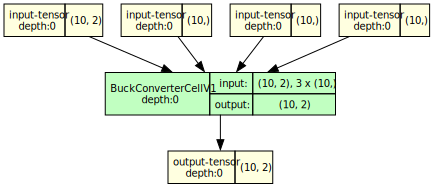

'tmp/model_graph_torchview.png'

In [134]:
model_graph = draw_graph(
    model,
    input_data=[h_dummy, vs_dummy, u_dummy, dt_dummy],
    expand_nested=True,
)
display(model_graph.visual_graph)

model_graph.visual_graph.render(filename="tmp/model_graph_torchview", format="png")

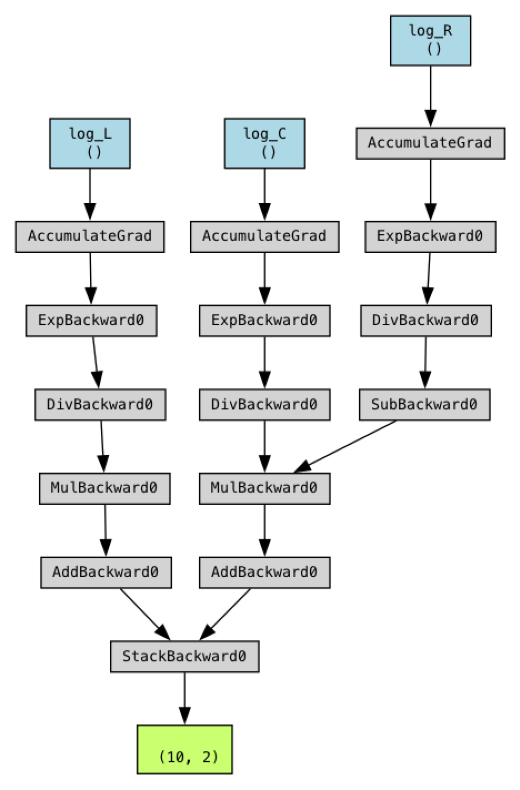

In [135]:
# モデルの可視化に torchviz を使用
# brew install graphviz でインストールする必要がある
y = model(h_dummy, vs_dummy, u_dummy, dt_dummy)
make_dot(
    y,
    params=dict(model.named_parameters()),
).render("tmp/model_graph_torchviz", format="png")


# 画像表示
img = Image.open("tmp/model_graph_torchviz.png")

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
plt.show()


# オイラー法

$$i_L(t + \Delta t) = i_L(t) + \frac{\Delta t}{L} (V_{in} * u(t) - v_c)$$

$$v_C(t + \Delta t) = v_C(t) + \frac{\Delta t}{C} \left( i_L - \frac{v_C}{R} \right)$$

# 線形 RNN で表す

BuckConverterRNNCell

$$
h_{t+1}
=
\underbrace{
\begin{bmatrix}
1 & -\frac{\Delta t}{L} \\
\frac{\Delta t}{C} & 1 - \frac{\Delta t}{CR}
\end{bmatrix}
}_{A}
h_t
+
\underbrace{
\begin{bmatrix}
\frac{\Delta t}{L} & 0 \\
0 & 0
\end{bmatrix}
}_{B}
\begin{bmatrix}
v_s(t) \\
u(t)
\end{bmatrix}
+
c
$$

$$v_s(t) = V_{in} * u(t)$$

$$
h_t =
\begin{bmatrix}
i_L(t) \\
v_C(t)
\end{bmatrix}
$$

BuckConverterRNNModel は、BuckConverterRNNCell を繰り返し適用して自己ループを再現する


In [136]:
class BuckConverterRNNCell(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # A と B をパラメータとして学習
        self.A: nn.Parameter = nn.Parameter(torch.randn(2, 2))
        self.B: nn.Parameter = nn.Parameter(torch.randn(2, 2))
        self.c: nn.Parameter = nn.Parameter(torch.zeros(2))

    def forward(self, h: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        # h: [Batch, 2] = [iL, vC]
        # x: [Batch, 2] = [vs, u]
        return h @ self.A.T + x @ self.B.T + self.c


class BuckConverterRNNModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.cell = BuckConverterRNNCell()

    def forward(self, h0: torch.Tensor, xs: torch.Tensor) -> torch.Tensor:
        """
        h0: [B, 2] 初期状態
        xs: [TimeStep, Batch, 2] 各時刻の入力 [vs, u]
        return: [TimeStep, Batch, 2]  各時刻の h_t
        """
        T, B, _ = xs.shape
        h = h0
        outputs = []
        for t in range(T):
            h = self.cell(h, xs[t])  # 自己ループ
            outputs.append(h)
        return torch.stack(outputs, dim=0)


## モデルの可視化


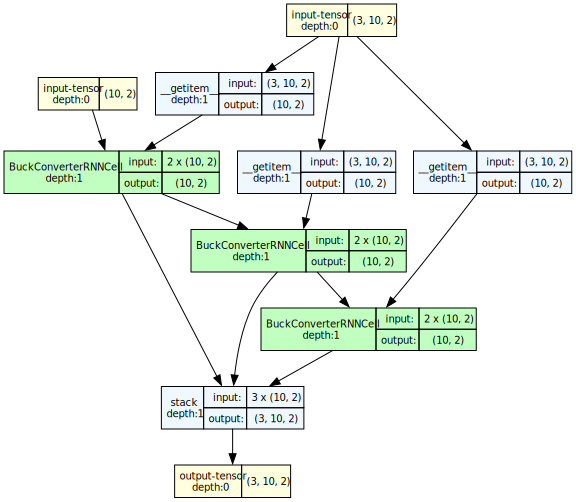

'tmp/model_graph_torchview.png'

In [137]:
model = BuckConverterRNNModel()

# ダミーデータを作成
h_dummy = torch.randn(batch_size, 2)  # [Batch, 2] = [iL, vC]
x_dummy = torch.randn(3, batch_size, 2)  # [TimeStep, Batch, 2] = [vs, u]

model_graph = draw_graph(
    model,
    input_data=[h_dummy, x_dummy],
    expand_nested=True,
)
display(model_graph.visual_graph)

model_graph.visual_graph.render(
    filename="tmp/model_graph_torchview",
    format="png",
)

## 新しく定義した BuckConverterRNNModel で学習させてみる

古いモデル(BuckConverterCellV1)で学習データを作る


len(t)=200001
len(dt)=200000
len(u)=200000
len(vs)=200000


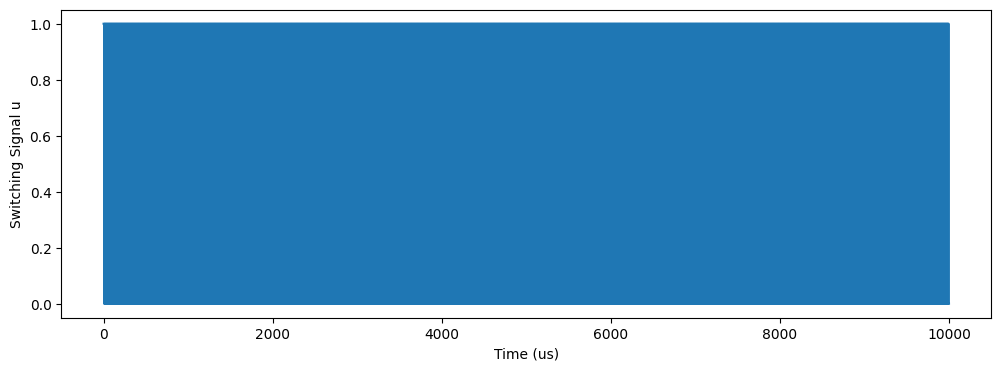

In [138]:
# 学習データを作成
L_true: float = 100e-6
C_true: float = 48e-6
R_true: float = 10

Vin: float = 10
Vref: float = 6
duty: float = Vref / Vin
f_sw: float = 1e5  # スイッチング周波数
T: float = 1 / f_sw  # 1周期の実時間
points_per_cycle: int = 200  # 1周期あたりのプロット数
cycles: int = 1000  # 周期数

t: np.ndarray = np.linspace(0, cycles * T, cycles * points_per_cycle + 1)
dt: np.ndarray = np.diff(t)

# スイッチング信号
duty_phase = (t[:-1] % T) / T
u = (duty_phase < duty).astype(int)

# 入力電圧
vs = np.ones(len(t) - 1) * Vin

print(f"{len(t)=}")
print(f"{len(dt)=}")
print(f"{len(u)=}")
print(f"{len(vs)=}")

# プロット
plt.figure(figsize=(12, 4))
plt.step(t[:-1] * 1e6, u, where="post")
plt.xlabel("Time (us)")
plt.ylabel("Switching Signal u")
plt.show()

In [139]:
# モデルを作成
model_true = BuckConverterCellV1(L_init=L_true, C_init=C_true, R_init=R_true)

# numpy配列をテンソルに変換
vs_tensor = torch.tensor(vs, dtype=torch.float32)
u_tensor = torch.tensor(u, dtype=torch.float32)
dt_tensor = torch.tensor(dt, dtype=torch.float32)

il_list = []
vc_list = []

# シミュレーション実行
with torch.no_grad():
    h_current: torch.Tensor = torch.zeros(1, 2)  # [i_L=0, v_C=0]
    for j in range(len(t) - 1):
        # 現在の状態を保存
        il_list.append(h_current[0, 0].item())  # i_L
        vc_list.append(h_current[0, 1].item())  # v_C

        h_current = model_true(h_current, vs_tensor[j], u_tensor[j], dt_tensor[j])


iL = torch.tensor(np.array(il_list), dtype=torch.float32)
vC = torch.tensor(np.array(vc_list), dtype=torch.float32)

print(iL.shape)
print(vC.shape)


torch.Size([200000])
torch.Size([200000])


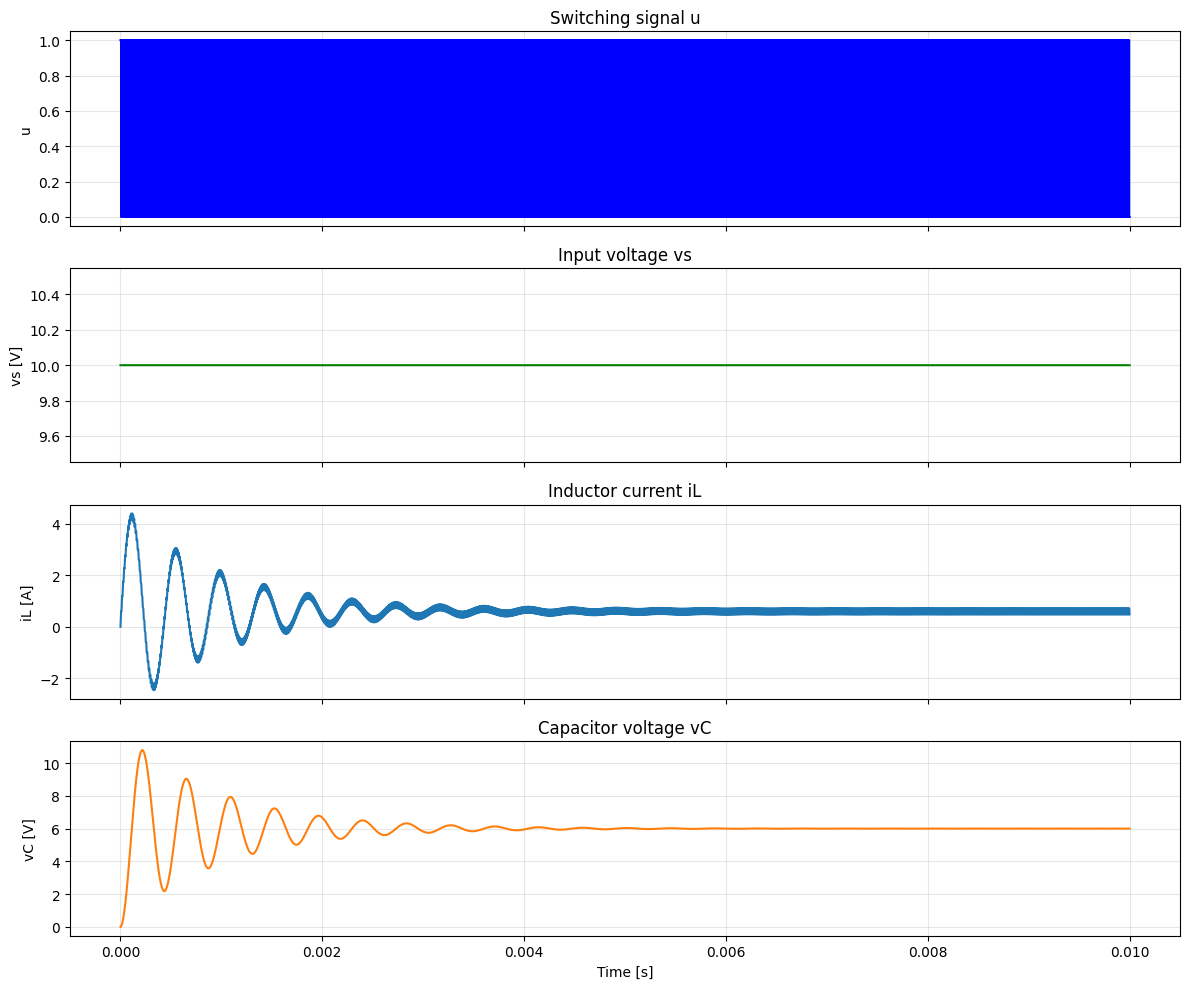

In [140]:
fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# 1: u (switching signal)
axs[0].step(t[:-1], u, where="post", color="blue", linewidth=1.5)
axs[0].set_ylabel("u")
axs[0].grid(True, alpha=0.3)
axs[0].set_title("Switching signal u")

# 2: vs (input voltage)
axs[1].plot(t[:-1], vs, color="green", linewidth=1.5)
axs[1].set_ylabel("vs [V]")
axs[1].grid(True, alpha=0.3)
axs[1].set_title("Input voltage vs")

# 3: iL (inductor current)
axs[2].plot(t[:-1], iL, color="tab:blue", linewidth=1.5)
axs[2].set_ylabel("iL [A]")
axs[2].grid(True, alpha=0.3)
axs[2].set_title("Inductor current iL")

# 4: vC (capacitor voltage)
axs[3].plot(t[:-1], vC, color="tab:orange", linewidth=1.5)
axs[3].set_ylabel("vC [V]")
axs[3].set_xlabel("Time [s]")
axs[3].grid(True, alpha=0.3)
axs[3].set_title("Capacitor voltage vC")

plt.tight_layout()
plt.show()


In [141]:
# 前処理
# 定常の10周期分
t_10 = t[-points_per_cycle * 10 - 1 :]
dt_10 = dt[-points_per_cycle * 10 :]
u_10 = u[-points_per_cycle * 10 :]
vs_10 = vs[-points_per_cycle * 10 :]
iL_10 = iL[-points_per_cycle * 10 :]
vC_10 = vC[-points_per_cycle * 10 :]

# numpy配列をテンソルに変換
dt_10_tensor = torch.tensor(dt_10, dtype=torch.float32)
u_10_tensor = torch.tensor(u_10, dtype=torch.float32)
vs_10_tensor = torch.tensor(vs_10, dtype=torch.float32)

# train
train_ratio = 0.3
train_len = int(len(t_10) * train_ratio)

t_train = t_10[:train_len]
dt_train = dt_10_tensor[:train_len]
u_train = u_10_tensor[:train_len]
vs_train = vs_10_tensor[:train_len]
iL_train = iL_10[:train_len]
vC_train = vC_10[:train_len]

# test
test_ratio = 0.3
test_len = int(len(t_10) * test_ratio)

t_test = t_10[train_len : train_len + test_len]
dt_test = dt_10_tensor[train_len : train_len + test_len]
iL_test = iL_10[train_len : train_len + test_len]
vC_test = vC_10[train_len : train_len + test_len]
u_test = u_10_tensor[train_len : train_len + test_len]
vs_test = vs_10_tensor[train_len : train_len + test_len]

# valid
t_valid = t_10[train_len + test_len :]
dt_valid = dt_10_tensor[train_len + test_len :]
iL_valid = iL_10[train_len + test_len :]
vC_valid = vC_10[train_len + test_len :]
u_valid = u_10_tensor[train_len + test_len :]
vs_valid = vs_10_tensor[train_len + test_len :]


print(f"{len(dt_train)=}")
print(f"{len(dt_test)=}")
print(f"{len(dt_valid)=}")


len(dt_train)=600
len(dt_test)=600
len(dt_valid)=800


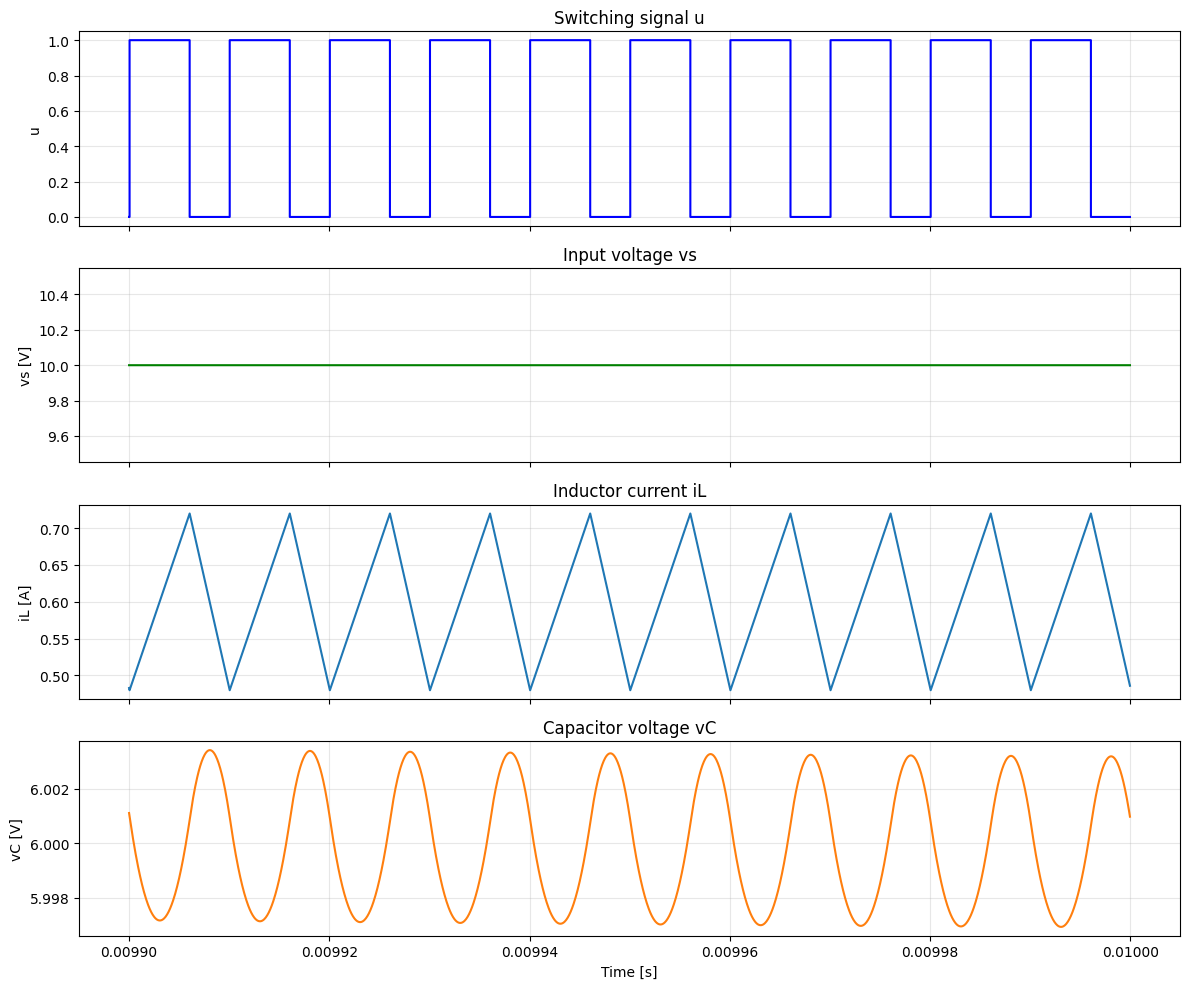

In [142]:
fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# 1: u (switching signal)
axs[0].step(t_10[:-1], u_10, where="post", color="blue", linewidth=1.5)
axs[0].set_ylabel("u")
axs[0].grid(True, alpha=0.3)
axs[0].set_title("Switching signal u")

# 2: vs (input voltage)
axs[1].plot(t_10[:-1], vs_10, color="green", linewidth=1.5)
axs[1].set_ylabel("vs [V]")
axs[1].grid(True, alpha=0.3)
axs[1].set_title("Input voltage vs")

# 3: iL (inductor current)
axs[2].plot(t_10[:-1], iL_10, color="tab:blue", linewidth=1.5)
axs[2].set_ylabel("iL [A]")
axs[2].grid(True, alpha=0.3)
axs[2].set_title("Inductor current iL")

# 4: vC (capacitor voltage)
axs[3].plot(t_10[:-1], vC_10, color="tab:orange", linewidth=1.5)
axs[3].set_ylabel("vC [V]")
axs[3].set_xlabel("Time [s]")
axs[3].grid(True, alpha=0.3)
axs[3].set_title("Capacitor voltage vC")

plt.tight_layout()
plt.show()


## 学習


In [143]:
# 学習データの準備
# BuckConverterRNNModelの入力形式に合わせてデータを整形
# h0: [B, 2] 初期状態
# xs: [TimeStep, Batch, 2] 各時刻の入力 [vs, u]
# h_target: [TimeStep, Batch, 2] 各時刻の目標状態 [iL, vC]

# trainデータ
h0_train = torch.stack([iL_train[0:1], vC_train[0:1]], dim=1)  # [1, 2]
xs_train = torch.stack(
    [
        vs_train.unsqueeze(1),  # [TimeStep, 1]
        u_train.unsqueeze(1),  # [TimeStep, 1]
    ],
    dim=2,
)  # [TimeStep, 1, 2]
h_target_train = torch.stack(
    [iL_train.unsqueeze(1), vC_train.unsqueeze(1)], dim=2
)  # [TimeStep, 1, 2]

# validデータ
h0_valid = torch.stack([iL_valid[0:1], vC_valid[0:1]], dim=1)  # [1, 2]
xs_valid = torch.stack(
    [
        vs_valid.unsqueeze(1),  # [TimeStep, 1]
        u_valid.unsqueeze(1),  # [TimeStep, 1]
    ],
    dim=2,
)  # [TimeStep, 1, 2]
h_target_valid = torch.stack(
    [iL_valid.unsqueeze(1), vC_valid.unsqueeze(1)], dim=2
)  # [TimeStep, 1, 2]

# testデータ（学習完了後に最終評価で使用）
h0_test = torch.stack([iL_test[0:1], vC_test[0:1]], dim=1)  # [1, 2]
xs_test = torch.stack(
    [
        vs_test.unsqueeze(1),  # [TimeStep, 1]
        u_test.unsqueeze(1),  # [TimeStep, 1]
    ],
    dim=2,
)  # [TimeStep, 1, 2]
h_target_test = torch.stack(
    [iL_test.unsqueeze(1), vC_test.unsqueeze(1)], dim=2
)  # [TimeStep, 1, 2]

print(f"{h0_train.shape=}")
print(f"{xs_train.shape=}")
print(f"{h_target_train.shape=}")
print(f"{h0_valid.shape=}")
print(f"{xs_valid.shape=}")
print(f"{h_target_valid.shape=}")
print(f"{h0_test.shape=}")
print(f"{xs_test.shape=}")
print(f"{h_target_test.shape=}")


h0_train.shape=torch.Size([1, 2])
xs_train.shape=torch.Size([600, 1, 2])
h_target_train.shape=torch.Size([600, 1, 2])
h0_valid.shape=torch.Size([1, 2])
xs_valid.shape=torch.Size([800, 1, 2])
h_target_valid.shape=torch.Size([800, 1, 2])
h0_test.shape=torch.Size([1, 2])
xs_test.shape=torch.Size([600, 1, 2])
h_target_test.shape=torch.Size([600, 1, 2])


In [144]:
# 学習パラメータ
epochs = 1000
lr = 1e-3

# モデルとオプティマイザーの設定
model = BuckConverterRNNModel()
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

# 損失履歴を保存
train_loss_history = []
valid_loss_history = []

# 学習ループ
for epoch in range(epochs):
    # 学習モード
    model.train()
    optimizer.zero_grad()

    # 予測
    h_pred_train = model(h0_train, xs_train)  # [TimeStep, Batch, 2]

    # 損失計算
    train_loss = loss_fn(h_pred_train, h_target_train)
    train_loss.backward()
    optimizer.step()

    train_loss_history.append(train_loss.item())

    # 検証モード（勾配計算なし）
    model.eval()
    with torch.no_grad():
        h_pred_valid = model(h0_valid, xs_valid)  # [TimeStep, Batch, 2]
        valid_loss = loss_fn(h_pred_valid, h_target_valid)
        valid_loss_history.append(valid_loss.item())

    if epoch % 50 == 0:
        print(
            f"Epoch {epoch}: Train Loss={train_loss.item():.6e}, "
            f"Valid Loss={valid_loss.item():.6e}"
        )
else:
    print("学習完了")
    print(
        f"Epoch {epoch}: Train Loss={train_loss.item():.6e}, "
        f"Valid Loss={valid_loss.item():.6e}"
    )


Epoch 0: Train Loss=9.162102e+01, Valid Loss=9.062256e+01
Epoch 50: Train Loss=5.640268e+01, Valid Loss=5.592844e+01
Epoch 100: Train Loss=3.944067e+01, Valid Loss=3.916611e+01
Epoch 150: Train Loss=2.931977e+01, Valid Loss=2.912957e+01
Epoch 200: Train Loss=2.255038e+01, Valid Loss=2.240848e+01
Epoch 250: Train Loss=1.804027e+01, Valid Loss=1.793270e+01
Epoch 300: Train Loss=1.538331e+01, Valid Loss=1.529687e+01
Epoch 350: Train Loss=1.415312e+01, Valid Loss=1.406324e+01
Epoch 400: Train Loss=1.362009e+01, Valid Loss=1.352084e+01
Epoch 450: Train Loss=1.316235e+01, Valid Loss=1.306950e+01
Epoch 500: Train Loss=1.270163e+01, Valid Loss=1.261305e+01
Epoch 550: Train Loss=1.223269e+01, Valid Loss=1.214764e+01
Epoch 600: Train Loss=1.175659e+01, Valid Loss=1.167486e+01
Epoch 650: Train Loss=1.127562e+01, Valid Loss=1.119714e+01
Epoch 700: Train Loss=1.079208e+01, Valid Loss=1.071687e+01
Epoch 750: Train Loss=1.030814e+01, Valid Loss=1.023625e+01
Epoch 800: Train Loss=9.825801e+00, Valid L


=== 学習済みモデルのパラメータ ===
A matrix:
tensor([[-1.0917,  0.1426],
        [-1.2775,  0.5258]])

B matrix:
tensor([[0.7840, 1.8773],
        [0.7824, 0.9847]])

c vector:
tensor([-0.4440,  0.1446])


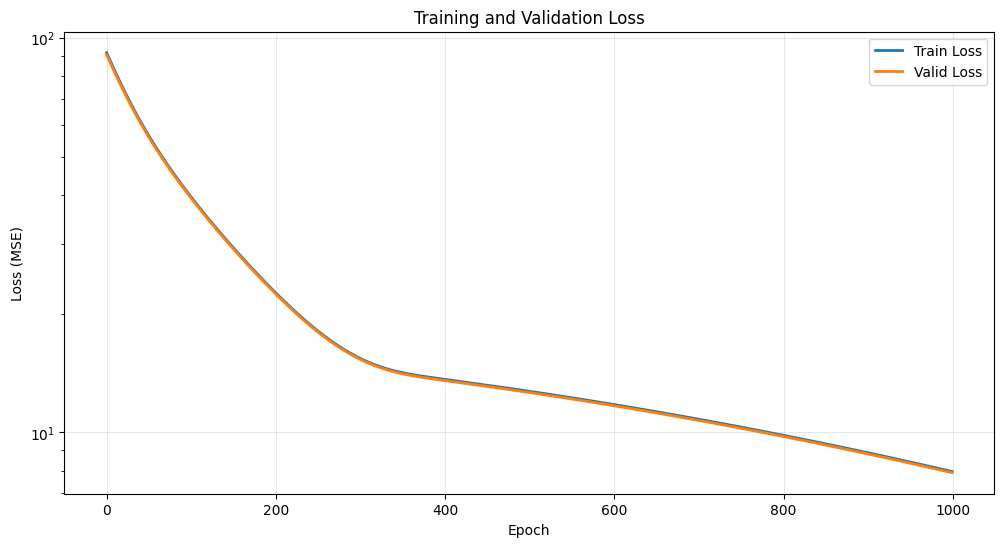

In [145]:
# 学習結果の可視化（1つのグラフのみ）
fig, ax = plt.subplots(figsize=(12, 6))

# 損失関数の履歴
ax.semilogy(train_loss_history, label="Train Loss", linewidth=2)
ax.semilogy(valid_loss_history, label="Valid Loss", linewidth=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss (MSE)")
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_title("Training and Validation Loss")

# 学習済みモデルのパラメータ表示
print("\n=== 学習済みモデルのパラメータ ===")
print(f"A matrix:\n{model.cell.A.data}")
print(f"\nB matrix:\n{model.cell.B.data}")
print(f"\nc vector:\n{model.cell.c.data}")

In [146]:
# テストデータでの評価（学習完了後の最終評価）
model.eval()
with torch.no_grad():
    h_pred_test = model(h0_test, xs_test)  # [TimeStep, Batch, 2]
    test_loss = loss_fn(h_pred_test, h_target_test)

print("\n=== 評価結果 ===")
print(f"Train Loss: {train_loss_history[-1]:.6e}")
print(f"Valid Loss: {valid_loss_history[-1]:.6e}")
print(f"Test Loss: {test_loss.item():.6e}")

# 予測結果を1次元に変換
iL_pred_test = h_pred_test[:, 0, 0].cpu().numpy()
vC_pred_test = h_pred_test[:, 0, 1].cpu().numpy()
iL_true_test = iL_test.cpu().numpy()
vC_true_test = vC_test.cpu().numpy()



=== 評価結果 ===
Train Loss: 7.955911e+00
Valid Loss: 7.900839e+00
Test Loss: 7.946820e+00


In [147]:
# シミュレーションしてみる
# BuckConverterRNNModelは時系列全体を一度に処理する形式
with torch.no_grad():
    # iL_10, vC_10の初期値を使って初期状態を設定
    h0_sim = torch.tensor([[iL_10[0], vC_10[0]]], dtype=torch.float32)
    # 定常状態の10周期分のデータを使う（vs_10_tensor, u_10_tensor）
    # xs: [TimeStep, Batch, 2] の形式に整形
    xs_sim = torch.stack(
        [
            vs_10_tensor.unsqueeze(1),  # [TimeStep, 1]
            u_10_tensor.unsqueeze(1),  # [TimeStep, 1]
        ],
        dim=2,
    )  # [TimeStep, 1, 2]

    # 全時系列を一度に予測
    h_pred_sim = model(h0_sim, xs_sim)  # [TimeStep, Batch, 2]

    # 予測結果を1次元に変換
    il_sim = h_pred_sim[:, 0, 0].cpu().numpy()
    vc_sim = h_pred_sim[:, 0, 1].cpu().numpy()

print(len(il_sim))
print(len(vc_sim))


2000
2000


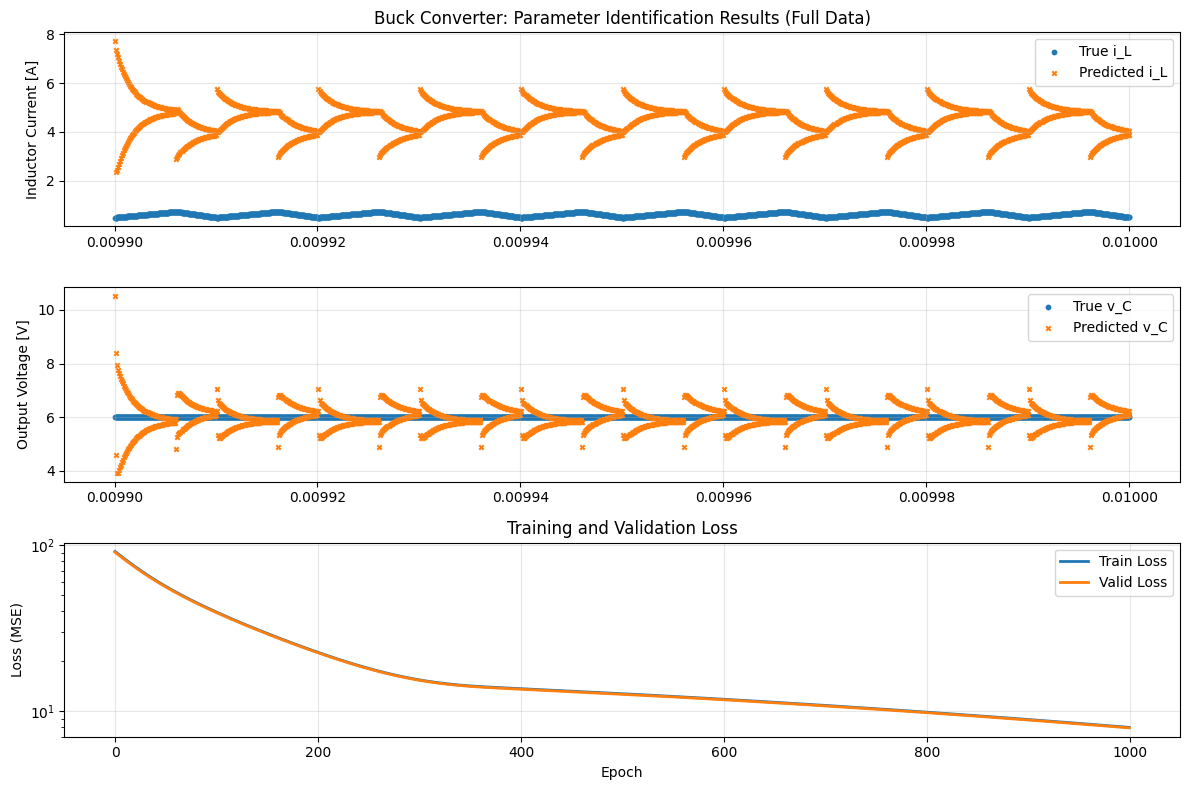

In [148]:
# 全データでのシミュレーション結果（点表示）
fig, axes = plt.subplots(3, 1, figsize=(12, 8))
time = t_10[1:]

# インダクタ電流（線ではなく点で表示）
axes[0].scatter(time, iL_10, label="True i_L", s=10)
axes[0].scatter(time, il_sim, label="Predicted i_L", s=10, marker="x")
axes[0].set_ylabel("Inductor Current [A]")
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_title("Buck Converter: Parameter Identification Results (Full Data)")

# キャパシタ電圧（線ではなく点で表示）
axes[1].scatter(time, vC_10, label="True v_C", s=10)
axes[1].scatter(time, vc_sim, label="Predicted v_C", s=10, marker="x")
axes[1].set_ylabel("Output Voltage [V]")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 損失関数の履歴は線のまま（点はわかりにくいため）
axes[2].semilogy(train_loss_history, label="Train Loss", linewidth=2)
axes[2].semilogy(valid_loss_history, label="Valid Loss", linewidth=2)
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Loss (MSE)")
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].set_title("Training and Validation Loss")

plt.tight_layout()
plt.show()


## 回路パラメータ(A,B,c)と真の値の比較

In [152]:
# 学習済みモデルのパラメータ表示
print("\n=== 学習済みモデルのパラメータ ===")
print(f"A matrix:\n{model.cell.A.data}")
print(f"\nB matrix:\n{model.cell.B.data}")
print(f"\nc vector:\n{model.cell.c.data}")


true_A = torch.tensor(
    [
        [
            1,
            -dt[0] / L_true,
        ],
        [
            dt[0] / C_true,
            1 - dt[0] / C_true / R_true,
        ],
    ]
)
true_B = torch.tensor([[dt[0] / L_true, 0], [0, 0]])
true_c = torch.tensor([0, 0])

print("\n=== True Parameters ===")
print(f"True A matrix:\n{true_A}")
print(f"\nTrue B matrix:\n{true_B}")
print(f"\nTrue c vector:\n{true_c}")


=== 学習済みモデルのパラメータ ===
A matrix:
tensor([[-1.0917,  0.1426],
        [-1.2775,  0.5258]])

B matrix:
tensor([[0.7840, 1.8773],
        [0.7824, 0.9847]])

c vector:
tensor([-0.4440,  0.1446])

=== True Parameters ===
True A matrix:
tensor([[ 1.0000e+00, -5.0000e-04],
        [ 1.0417e-03,  9.9990e-01]], dtype=torch.float64)

True B matrix:
tensor([[0.0005, 0.0000],
        [0.0000, 0.0000]], dtype=torch.float64)

True c vector:
tensor([0, 0])


# まとめ


- モデルの定義方法を変えることはおそらくできた
- ただ、前まで使っていたモデルは、セル(BuckConverterRNNCell)と同じようなことで多分RNNのセルを示していただけで、負の値を持たないように実装するときに前の実装の方がやりやすかっただけだと思う
- 今回は、A,B,cをパラメータとして学習するので、どれがどのくらいの範囲でClamするとかlogで負の値をブロックするとかが難しいんだと思う
- 実際今回は、パラメータが全然外れまくってる

```
=== 学習済みモデルのパラメータ ===
A matrix:
tensor([[-1.0917,  0.1426],
        [-1.2775,  0.5258]])

B matrix:
tensor([[0.7840, 1.8773],
        [0.7824, 0.9847]])

c vector:
tensor([-0.4440,  0.1446])

=== True Parameters ===
True A matrix:
tensor([[ 1.0000e+00, -5.0000e-04],
        [ 1.0417e-03,  9.9990e-01]], dtype=torch.float64)

True B matrix:
tensor([[0.0005, 0.0000],
        [0.0000, 0.0000]], dtype=torch.float64)

True c vector:
tensor([0, 0])
```


# 次やること
- 一旦、パラメータの中で0のところや1のところを固定にして、学習によって変化しないようにしてみる